## **Building a Dataset for Indian Mutual Funds**

### **Part 1: Make the Raw Data Usable**

We have a dataset that's been gathered, but it's largely unusable at this point. To do PCA analysis (if applicable-- but the data is monodimensional so that may be futile)/EDA, we need things to be in a readable structure.

#### A. Load the Data

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
### run once *if amfi mutual fund nav dataset doesn't exist*
### otherwise, keep commented out

# # Fetch AMFI Mutual Fund NAV Data
# amfi_url = "https://www.amfiindia.com/spages/NAVAll.txt"
# headers = {'User-Agent': 'Mozilla/5.0'}

# # Get the raw text response
# response = requests.get(amfi_url, headers=headers)
# data = response.text

# # Convert text into a list of lines
# lines = data.split("\n")

# # Identify where the actual data starts (ignoring headers like "Open Ended Schemes")
# start_index = next(i for i, line in enumerate(lines) if line.startswith("Scheme Code"))

# # Extract only the tabular data
# data_cleaned = "\n".join(lines[start_index:])

# # Read into Pandas DataFrame
# df_mutual_funds = pd.read_csv(StringIO(data_cleaned), delimiter=";", encoding="latin1")

# # Clean column names (remove spaces)
# df_mutual_funds.columns = df_mutual_funds.columns.str.strip()

# # Convert Date column to datetime
# df_mutual_funds['Date'] = pd.to_datetime(df_mutual_funds['Date'], errors='coerce')

# # Keep relevant columns
# df_mutual_funds = df_mutual_funds[['Date', 'Scheme Name', 'Net Asset Value']]

# # Remove rows with missing data
# df_mutual_funds = df_mutual_funds.dropna()

# # Sort by date
# df_mutual_funds = df_mutual_funds.sort_values(by='Date')

# # Save cleaned data as CSV
# df_mutual_funds.to_csv("data/india_mutual_funds_cleaned.csv", index=False)

# # Display first few rows
# print(df_mutual_funds.head())

In [20]:
file_paths = {
    "motilal_oswal": "data/motilaloswalmfi.csv",
    "amfi_india": "data/india_mutual_funds_cleaned.csv"
}

dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

#### B. Pre-Process the Data

We won't be able to do anything with the datasets without cleaning, making them consistent with each other, combining, etc.

In [ ]:
# for easy reference..
df1 = dfs["motilal_oswal"].copy()
df2 = dfs["amfi_india"].copy()

"""
# Data Cleaning and Preparation
This section loads and cleans the datasets to ensure they are in a usable format.
"""

# Data Cleaning Function
def clean_data(df, scheme_col='Scheme Name', nav_col='Net Asset Value', date_col='Date'):
    df = df.rename(columns={scheme_col: 'Scheme_Name', nav_col: 'NAV', date_col: 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['NAV'] = pd.to_numeric(df['NAV'], errors='coerce')
    df = df.dropna().reset_index(drop=True)
    return df

# Clean both datasets
df1_cleaned = clean_data(df1)
df2_cleaned = clean_data(df2)

# Merge datasets for joint analysis
df_combined = pd.concat([df1_cleaned, df2_cleaned], ignore_index=True)

In [30]:
df_combined.head()

,Scheme Code,Scheme_Name,ISIN Div Payout/ISIN Growth,ISIN Div Reinvestment,NAV,Repurchase Price,Sale Price,Date,Rolling_Volatility
0,NaN,BANDHAN LIQUID FUND - Inst Plan B - Periodic Div,NaN,NaN,0.0000,NaN,NaN,2008-10-02,NaN
1,NaN,ICICI Prudential Medium Term Bond Fund Plan A ...,NaN,NaN,10.0458,NaN,NaN,2012-02-17,NaN
2,NaN,HDFC Liquid Fund-Premium Plus Plan - Dividend-...,NaN,NaN,10.0000,NaN,NaN,2012-05-14,NaN
3,NaN,SBI ONE INDIA FUND - DIVIDEND (PREVIOUSLY CLOS...,NaN,NaN,10.4300,NaN,NaN,2012-08-10,NaN
4,NaN,SBI ONE INDIA FUND - GROWTH (PREVIOUSLY CLOSE ...,NaN,NaN,10.4300,NaN,NaN,2012-08-10,NaN


In [34]:
# df_combined.to_csv("data/combined_df.csv", index=False)

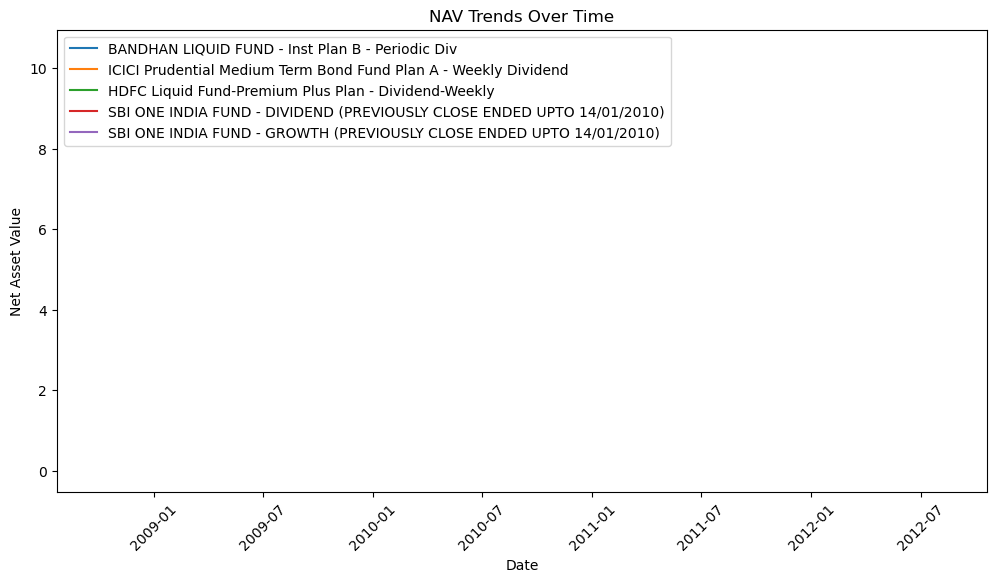

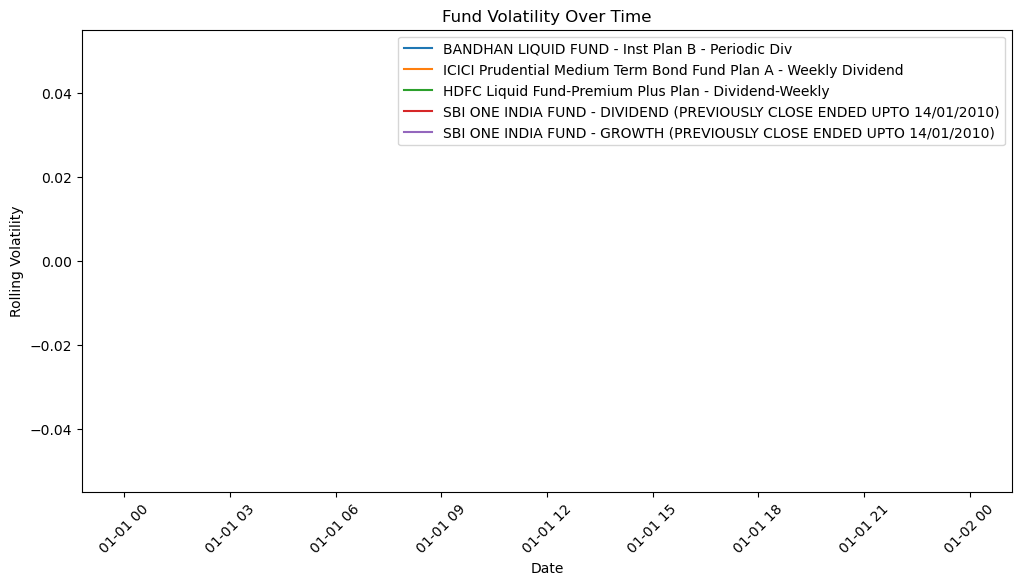

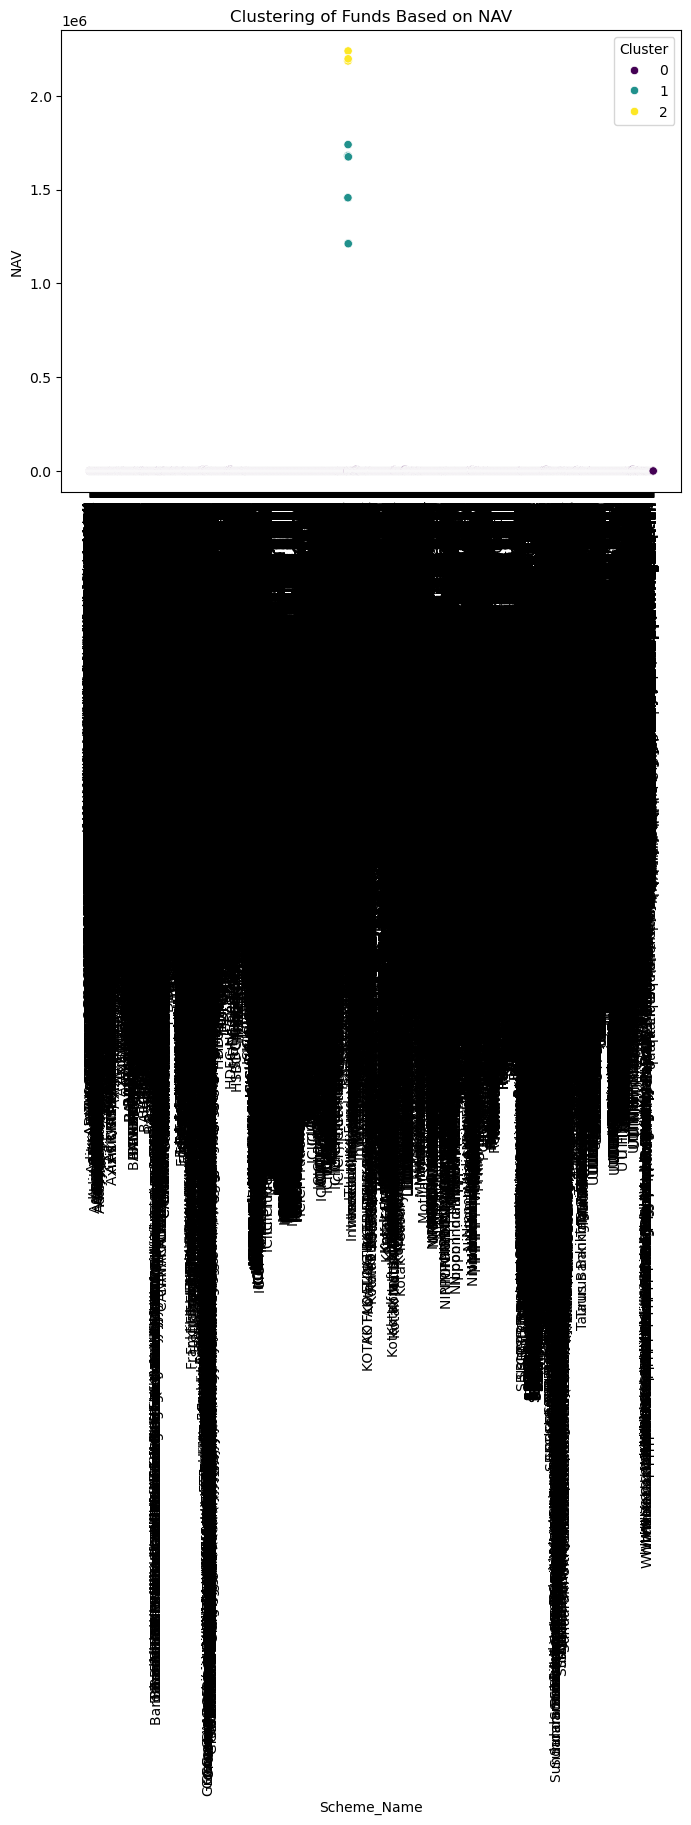

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


KeyboardInterrupt: 

In [26]:
"""
# Exploratory Data Analysis (EDA)
In this section, we will explore the cleaned data using different visualizations.
"""

"""
## NAV Trends Over Time
This function plots the NAV changes over time for different funds.
"""
def plot_nav_trends(df):
    plt.figure(figsize=(12, 6))
    for scheme in df['Scheme_Name'].unique()[:5]:  # Limit to 5 schemes for clarity
        scheme_df = df[df['Scheme_Name'] == scheme]
        plt.plot(scheme_df['Date'], scheme_df['NAV'], label=scheme)
    plt.xlabel("Date")
    plt.ylabel("Net Asset Value")
    plt.title("NAV Trends Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

"""
## Rolling Volatility Analysis
Calculates and plots rolling standard deviation to measure fund stability.
"""
def plot_rolling_volatility(df, window=30):
    df['Rolling_Volatility'] = df.groupby('Scheme_Name')['NAV'].transform(lambda x: x.rolling(window).std())
    plt.figure(figsize=(12, 6))
    for scheme in df['Scheme_Name'].unique()[:5]:
        scheme_df = df[df['Scheme_Name'] == scheme]
        plt.plot(scheme_df['Date'], scheme_df['Rolling_Volatility'], label=scheme)
    plt.xlabel("Date")
    plt.ylabel("Rolling Volatility")
    plt.title("Fund Volatility Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

"""
## Clustering Analysis
Groups mutual funds into clusters based on NAV similarities.
"""
def cluster_funds(df, n_clusters=3):
    df_cluster = df.groupby('Scheme_Name')[['NAV']].mean().dropna()
    scaler = StandardScaler()
    df_cluster_scaled = scaler.fit_transform(df_cluster)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_cluster['Cluster'] = kmeans.fit_predict(df_cluster_scaled)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_cluster.index, y=df_cluster['NAV'], hue=df_cluster['Cluster'], palette='viridis')
    plt.xticks(rotation=90)
    plt.title("Clustering of Funds Based on NAV")
    plt.show()
    
    return df_cluster

"""
## Correlation Analysis
Examines relationships between different mutual funds based on NAV movements.
"""
def correlation_analysis(df):
    pivot_df = df.pivot(index='Date', columns='Scheme_Name', values='NAV').dropna()
    corr_matrix = pivot_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt='.2f')
    plt.title("Correlation Between Mutual Funds")
    plt.show()

"""
# Running the EDA Functions
Calling the defined functions to generate insights.
"""
plot_nav_trends(df_combined)
plot_rolling_volatility(df_combined)
df_clusters = cluster_funds(df_combined)
correlation_analysis(df_combined)
